# Using a self-attention based encoding model to predict brain activitiy from audio data

Do you like deep learning-based auditory encoding models?
Always wanted to train a deep recurrent model to predict brain activity from an auditory stimulus (i.e. spectrogram)?
Also interested in gaining some *interpretability* of whatever is learned by such a model in terms of the parts of the spectrogram that are important?

This library allows you to train a recurrent DNN (a GRU) and then learns a self-attention mechanism that weighs hidden states - the resulting weighted tensor is used to predict brain activity (or whatever you choose as a target).
It also contains many variations of this model type (CNN + GRU + attention, shared attention between targets, multi-head attention etc) and some functions for visualizing the computed attention weights on a spectrogram.

It's old-ish research code, so use at your own risk, but trained on a sufficiently large audio/brain dataset (I didn't explore the lower limit, but probably doesn't work below 30mins or so - depends on your Signal-to-Noise Ratio of course) it gives some interesting results - essentially uncovering that to predict brain activity from audio data well, we need some time invariance and "pay attention" (pun intended) to certain parts of the spectrogram (somewhat) independently from *when* they appear.

In [1]:
import numpy as np
import torch
from selfattention_audio import dataset_helpers as dhelp
from selfattention_audio import nn_helpers as nnhelp
from selfattention_audio import lightning_modules as light
from pytorch_lightning import Trainer
from selfattention_audio import extract_features_helper as ext
import matplotlib.pyplot as plt

from fit_model_example import plot_attention_with_specgram, create_lightning_model

We can now train a simple example model. It's Gated Recurrent Unit with attention applied to the hidden states of the last layer - this compresses all hidden states into one, which can be used to predict whatever brain activity one has recorded.

As we will see later, one nice use of the attention weights is that they assign an importance to each part of the spectrogram, we thus gain some interpretability over other deep models.

/home/mboos/anaconda3/envs/python3.7/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:224: UserWarning: Checkpoint directory ./saved_models/example_model_gru_single_head_attention exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  f"Checkpoint directory {filepath} exists and is not empty with save_top_k != 0."
INFO:root:
               Name                Type Params
0             model  GRU_with_attention  218 K
1         model.gru                 GRU  218 K
2    model.post_gru          Sequential  302  
3  model.post_gru.0              Linear  302  
4         model.att              Linear  151  
5         loss_func             MSELoss    0  
INFO:root:model and trainer restored from checkpoint: ./saved_models/example_model_gru_single_head_attention/gru_single_head_attention_ckpt_epoch_18.ckpt


Validation loss: 1.8809049129486084
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.19batch/s, batch_idx=1, loss=1.358, v_num=19]
                                                                                                                                                                                                                   

INFO:root:
Epoch 00018: val_loss reached 1.97937 (best 1.97937), saving model to ./saved_models/example_model_gru_single_head_attention/gru_single_head_attention_ckpt_epoch_18_v0.ckpt as top 1


Epoch 20:   0%|                                                                                                                                        | 0/4 [00:00<?, ?batch/s, batch_idx=1, loss=1.358, v_num=19]

/home/mboos/anaconda3/envs/python3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/training_io.py:342: UserWarning: Did not find hyperparameters at model.hparams. Saving checkpoint without hyperparameters
  "Did not find hyperparameters at model.hparams. Saving checkpoint without"


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.34batch/s, batch_idx=1, loss=1.348, v_num=19]
                                                                                                                                                                                                                   

INFO:root:
Epoch 00019: val_loss reached 1.91042 (best 1.91042), saving model to ./saved_models/example_model_gru_single_head_attention/gru_single_head_attention_ckpt_epoch_19.ckpt as top 1


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28batch/s, batch_idx=1, loss=1.337, v_num=19]
                                                                                                                                                                                                                   

INFO:root:
Epoch 00020: val_loss was not in top 1


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.76batch/s, batch_idx=1, loss=1.325, v_num=19]
                                                                                                                                                                                                                   

INFO:root:
Epoch 00021: val_loss was not in top 1


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.27batch/s, batch_idx=1, loss=1.315, v_num=19]
                                                                                                                                                                                                                   

INFO:root:
Epoch 00022: val_loss was not in top 1
INFO:root:Epoch 00023: early stopping


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.40batch/s, batch_idx=1, loss=1.315, v_num=19]


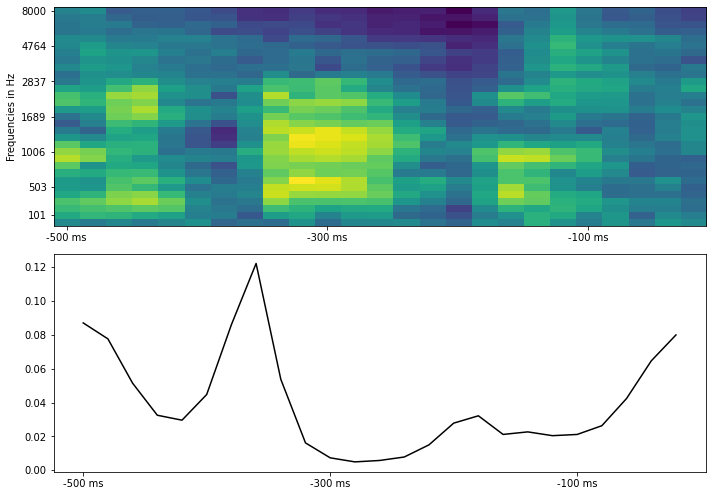

In [8]:
from pytorch_lightning.callbacks import ModelCheckpoint
import joblib

example_data = joblib.load("./tests/example_data.pkl")
train_data, test_data, val_data = [
    dhelp.AudioBrainDataset(
        example_data[f"features_{split}"],
        example_data[f"targets_{split}"],
        transform=None,
    )
    for split in ["train", "test", "val"]
]
model_params = dict(
    hidden_size=150,
    num_layers=2,
    n_patterns=30,
    n_window=5,
    n_targets=2,
    dropout=0.2,
)

nn_model = nnhelp.GRU_with_attention(**model_params)
model = create_lightning_model(train_data, test_data, val_data, nn_model=nn_model)

checkpoint_callback = ModelCheckpoint(
    filepath="./saved_models/example_model_gru_single_head_attention",
    verbose=True,
    monitor="val_loss",
    mode="min",
    prefix="gru_single_head_attention",
)

trainer = Trainer(max_nb_epochs=100, checkpoint_callback=checkpoint_callback)
trainer.fit(model)

gru_att_extractor = create_lightning_model(
    train_data,
    test_data,
    val_data,
    nn_model=ext.ExtractGRU_with_attention(**model_params),
)
gru_att_extractor.load_state_dict(model.state_dict())
# extract attention weights for each sample in the test set
attention = np.squeeze(
    gru_att_extractor.model(torch.tensor(test_data.features)).detach().numpy()
)

sample_to_plot = 200
_ = plot_attention_with_specgram(
    attention[sample_to_plot], test_data.features[sample_to_plot]
)


The resulting plot shows the attention weights that were computed for each part (hidden state) of the spectrogram.
When trained for long enough and with more data, the attention weights "latch on" to changes in the spectrogram, such as start and end of words or syllables.
If the data in your test features are contiguous in time, one nice visualization shows attention while the stimulus (spectrogram) develops across time.

In [75]:
def make_video_for_samples(attentions, features, vmin=None, vmax=None, interval=30):
    """Creates an animation for showing how attention develops over the features
    
    Attentions need to be a (sample, time_steps) array
    Features a (samples, time_steps, frequencies) array"""
    from matplotlib.animation import FuncAnimation
    import os
    vmin = features.min() if vmin is None else vmin
    vmax = features.max() if vmax is None else vmax
    att_max = attention.max()
    fig = plot_attention_with_specgram(attentions[0], features[0], vmin=vmin, vmax=vmax, att_max=att_max)
    im = fig.axes[0].images[0]
    line = fig.axes[1].get_children()[0]
    idx, _ = line.get_data()
    def animate_func(i):
        im.set_array(features[i+1].T)
        line.set_data(idx, attentions[i+1])

    # create animation using the animate() function
    myAnimation = FuncAnimation(fig, animate_func, frames=np.arange(features.shape[0]-1), \
                                          interval=50, blit=False, repeat=True)
    return myAnimation

<IPython.core.display.Javascript object>


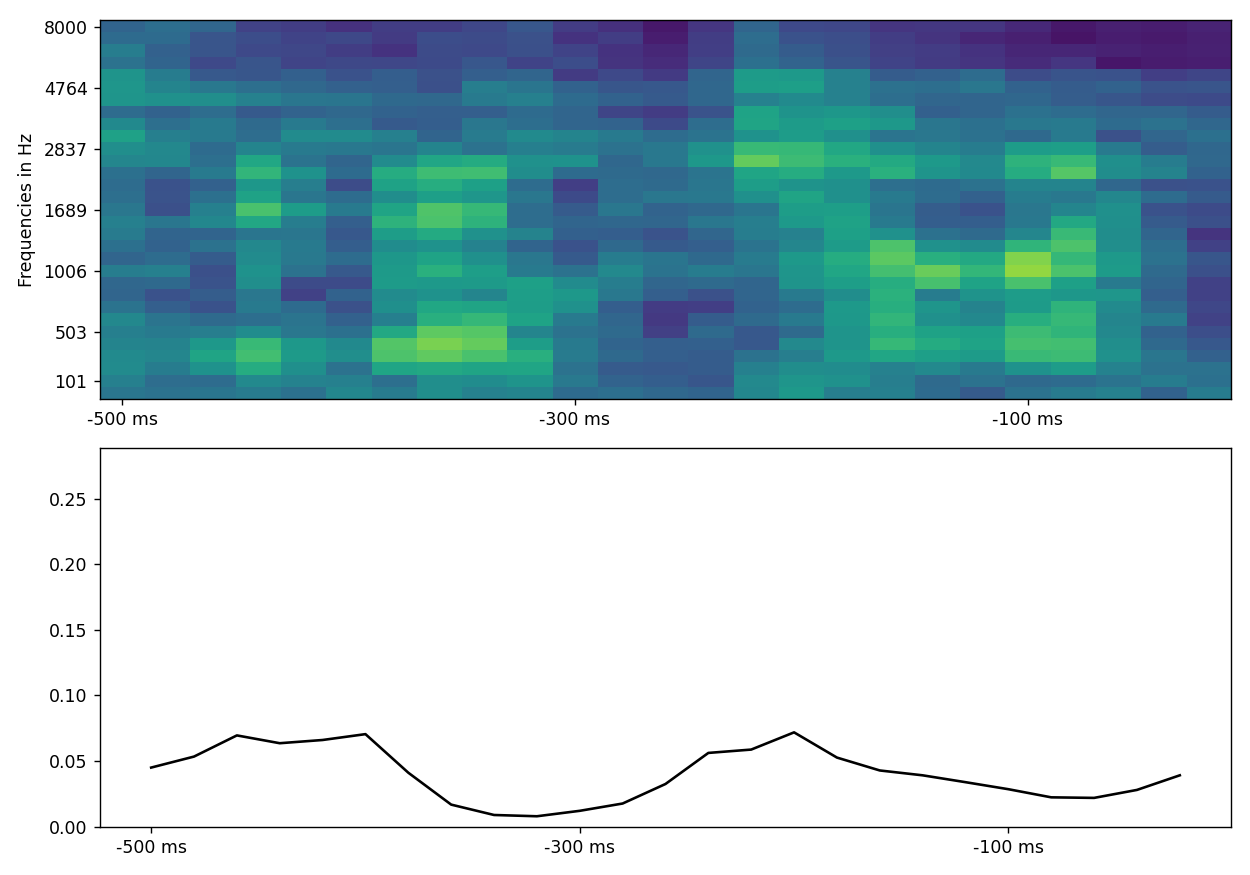

In [73]:
%matplotlib notebook
anim = make_video_for_samples(attention[170:270], test_data.features[170:270])

## How could this look like in your data?

Now this was trained on some very small example data, so what happens if we train this model on a larger amount of data?

This is an example of how results from actual audio/brain data can look like (brain activity is compressed in only 2 dimensions for visualization):

<img src="http://mjboos.github.io/files/animation_attention_example.gif" width="550" align="center">

A very simple heuristic to know what the model "pays attention to" is to identify parts of the stimulus to which attention is time-locked (e.g. attention assigns high weights even if this stimulus part is in the past) and compare it to parts of the stimulus that attention does not time-lock on:

<img src="http://mjboos.github.io/files/average_spec.png" width="550" align="center">

## How to load your data

The easiest way to adapt this analysis to your data is to just initialize `dataset_helpers.AudioBrainDataset` with your own preprocessed data and feed it into `lightning_modules.AuditoryEncodingLightning`.

As with all such analyses, you should "lag" your data, e.g. for each sample of the data, create a matrix of spectrogram features from *t* - X to *t* to predict brain activity at time *t* (where X will be your window length). In contrast to standard linear encoding models, we will not flatten this spectrogram across time/frequencies, but keep it as a *T X F* matrix (where *T* are your time steps and *F* your frequencies).
Take a look at the docstring to figure what to reshape in which way.